In [38]:

import pandas as pd
import re #regex library to format fast to read into pd
import os

import matplotlib.pyplot as plt
import feather

import numpy as np
import platform
import mne


from mne.channels import find_ch_adjacency, make_1020_channel_selections
from mne.stats import spatio_temporal_cluster_test
from mne.stats import (ttest_1samp_no_p, bonferroni_correction, fdr_correction,


                       permutation_t_test, permutation_cluster_1samp_test,spatio_temporal_cluster_1samp_test)
import sys
if platform.system()=='Darwin':
    os.chdir('/Volumes/BBC/BBC/WP1/data/EEG/tsk/')
    #sys.path.append('/Users/leupinv/BBC/WP1/data/Code/python/BBC')
    #if this doesn't work pound line right above this, restart the kernel, rerun the cell.
    #Then uncomment the same line and rerun

else:
    #os.chdir('Z:/BBC/WP1/data/EEG/tsk')
    #sys.path.append('C:/Users/Vivi/switchdrive/BBC/WP1/data/Code/python/BBC')
    os.chdir('Z:/BBC/WP1/data/EEG/tsk')

from base.files_in_out import getListOfFiles,GetFiles
from stats.stats_helper import filter_list, tTest_ana
import stats.t_tests_cluster as clus
import stats.stats_helper as s_hp
import base.base_constants as cs
from stats.stats_helper import filter_list, tTest_ana, filter_list_equal

In [39]:
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
mpl.rcParams['svg.fonttype']='none'
mpl.rcParams['text.usetex']=False
plt.style.use('default')

mpl.rcParams['svg.fonttype']='none'
mpl.rcParams['text.usetex']=False

In [40]:
def data_cutter(data, time_limits=[-0.3, 0.8], new_time_limits=[0.2, 0.6], sfreq=256):
    """
    Cuts a 3D EEG data array ( time x electrodes) based on specified time limits.
    Parameters:
        data (np.ndarray): EEG data of shape (electrodes, time)
        time_limits (list of float): Original epoch time range in seconds (e.g., [-0.3, 0.8])
        new_time_limits (list of float): Desired time range to extract (e.g., [0.2, 0.6])
        sfreq (int): Sampling frequency in Hz (default is 256)
    Returns:
        np.ndarray: The cut data with shape (new_time_points,electrodes)
    """
    # Calculate the sample indices corresponding to the new time limits
    start_idx = int(np.round((new_time_limits[0] - time_limits[0]) * sfreq))
    end_idx = int(np.round((new_time_limits[1] - time_limits[0]) * sfreq))
    # Cut the data along the time dimension (axis=1)
    return data[start_idx:end_idx,:]



# Get HBC data

In [3]:
filepath='Z:/BBC\WP1\data\EEG\int/ana/behav/group_n_int_acc_df.feather'
hbc_df=pd.read_feather(filepath)

<AxesSubplot:xlabel='mean_int', ylabel='Count'>

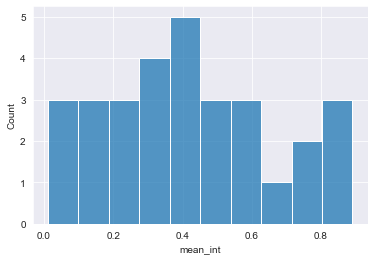

In [5]:
import seaborn as sns
sns.histplot(hbc_df['mean_int'],bins=10)

In [55]:
ax=sns.violinplot(data=hbc_df,x='mean_int',inner='box')
med=hbc_df['mean_int'].median()
ax.vlines(x=med,ymin=-0.4,ymax=0.4,color="red",linewidth=2.5)
#ax.set_xlim(0,1)

In [57]:
hbc_df['mean_int'].median()

0.403133414077417

In [56]:
plt.tight_layout()
file_dir='ana/deconvolution/figures/violinplot_HCT.svg'
plt.savefig(file_dir, format='svg')
plt.close()

In [30]:
hbc_df['mean_int'].describe()

count    30.000000
mean      0.415272
std       0.257280
min       0.011364
25%       0.199489
50%       0.403133
75%       0.601167
max       0.890804
Name: mean_int, dtype: float64

In [31]:
med=hbc_df['mean_int'].median()
hbc_low=hbc_df[hbc_df['mean_int']<med]

In [32]:
hbc_low

,20_mean_int,30_mean_int,45_mean_int,mean_int,g_num,n_none,cond
0,0.461154,0.384027,0.363454,0.402878,g03,0,n
0,0.106725,0.149676,0.123702,0.126701,g08,0,n
0,0.380000,0.360657,0.287543,0.342733,g11,0,n
0,0.239240,0.164935,0.181460,0.195212,g15,0,n
0,0.068182,0.221687,0.125870,0.138579,g17,0,n
0,0.293272,0.318080,0.296244,0.303104,g19,1,n
0,0.243399,0.184168,0.145937,0.191168,g25,0,n
0,0.127435,0.065104,0.113834,0.102125,g32,0,n
0,0.206296,0.589286,0.233701,0.343094,g37,0,n
0,0.408409,0.424122,0.300513,0.377681,g38,0,n


In [33]:
g_num_low=hbc_low['g_num']

In [34]:
hbc_high=hbc_df[hbc_df['mean_int']>=med]
hbc_high

,20_mean_int,30_mean_int,45_mean_int,mean_int,g_num,n_none,cond
0,0.426692,0.522783,0.519980,0.489818,g01,0,n
0,0.486038,0.351905,0.487202,0.441715,g10,0,n
0,0.722756,0.529632,0.566982,0.606457,g12,0,n
0,0.876105,0.836507,0.719530,0.810714,g16,0,n
0,0.697713,0.600105,0.738817,0.678878,g23,0,n
0,0.486025,0.635263,0.305222,0.475503,g24,0,n
0,0.627002,0.674194,0.563873,0.621689,g28,0,n
0,0.482172,0.385714,0.342279,0.403388,g33,0,n
0,0.443182,0.411319,0.425769,0.426757,g34,0,n
0,0.771711,0.762931,0.775898,0.770180,g41,0,n


In [35]:
g_num_high=hbc_high['g_num']

In [36]:
hbc_high['mean_int'].describe()

count    15.000000
mean      0.621719
std       0.165764
min       0.403388
25%       0.482661
50%       0.606457
75%       0.748853
max       0.890804
Name: mean_int, dtype: float64

In [37]:
hbc_low['mean_int'].describe()

count    15.000000
mean      0.208825
std       0.135303
min       0.011364
25%       0.114413
50%       0.195212
75%       0.338240
max       0.402878
Name: mean_int, dtype: float64

## aware vs unaware in aware fit

In [10]:
g_num='g01'
file_dir=f'ana/deconvolution/ep_betas/modfit/dc/{g_num}_modfit_hep_awareness_unaware_dc.ep'
f = open(file_dir)


In [11]:
data=np.loadtxt(file_dir)
data=data_cutter(data,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])

data.shape

(204, 128)

In [31]:
erp_type='hep'
modtype='awafit'
hbc_cond='low'
if hbc_cond=='high':
    subject_list=g_num_high
elif hbc_cond=='low':
    subject_list=g_num_low

X_awa=np.empty((len(subject_list),data.shape[1],data.shape[0]))
dc='dc'
for idx,g_num in enumerate(subject_list):
    file_dir=f'ana/deconvolution/ep_betas/awafit/{dc}/{g_num}_aware_hep__Intercept__{dc}.ep'
    data=np.loadtxt(file_dir)
    data=data_cutter(data,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])


    X_awa[idx,:,:]=data.T




In [32]:

X_unawa=np.empty((len(subject_list),data.shape[1],data.shape[0]))
for idx,g_num in enumerate(subject_list):
    file_dir=f'ana/deconvolution/ep_betas/awafit/{dc}/{g_num}_unaware_hep__Intercept__{dc}.ep'

    data=np.loadtxt(file_dir)
    data=data_cutter(data,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])

    X_unawa[idx,:,:]=data.T




In [33]:
X=X_awa-X_unawa

%matplotlib qt

s_hp.get_tTest(X,crop_value=[-0.1,0.7],FDR=False,p_val=0.01,plot_times=[0.505],averages=0.015)

### load bf

In [34]:
cond="awareness"
dc_type=dc

#load corresponding file



file_dir=f'ana/deconvolution/stats/BF_matrix_{modtype}_{erp_type}_{cond}_{dc_type}_hbc_{hbc_cond}.ep'
f = open(file_dir)

In [35]:
data_BF=np.loadtxt(file_dir)
data_BF=data_BF
data_BF=data_cutter(data_BF.T,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7]).T
data_BF.shape

(128, 204)

In [36]:
%matplotlib qt
filepath=f'{modtype}_{erp_type}_{cond}_{dc_type}_hbc_{hbc_cond}'
s_hp.get_tTest(X,crop_value=[-0.1,0.7],FDR=False,mask_BF=data_BF,BF=True, plot_times=[0.505],averages=0.015,png=filepath)

-0.1
number of time pointst: 8
length of minimum time points to be significant: 1
at the moment if only one TF is significant the electrode will be displayed as sig
(128, 204)


(array([[ 0.26935283,  0.07710084, -0.09286837, ...,  0.21043649,
          0.55068153,  0.96245235],
        [ 0.79733219,  0.45130106,  0.15863765, ..., -0.89529153,
         -0.67429131, -0.30215574],
        [ 0.56668644,  0.38189875,  0.28175989, ..., -0.71622483,
         -0.36693674,  0.06890154],
        ...,
        [-0.60637529, -0.43331895, -0.3803926 , ..., -1.21429062,
         -1.28818654, -1.17687756],
        [-0.1449332 ,  0.20512173,  0.40369063, ..., -1.46585003,
         -1.68677697, -1.59435448],
        [ 0.36406042,  0.79693398,  0.99026552, ..., -1.16616827,
         -1.33702058, -1.2485049 ]]),
 array([[0.79158735, 0.93963438, 0.92732403, ..., 0.83635898, 0.5905317 ,
         0.35215254],
        [0.43857261, 0.65868433, 0.87622   , ..., 0.38576584, 0.5111074 ,
         0.76697561],
        [0.57989958, 0.7082706 , 0.78224967, ..., 0.48562893, 0.71915299,
         0.94604244],
        ...,
        [0.55397144, 0.67138497, 0.70936314, ..., 0.2447228 , 0.21856531

# Compute gavgs

In [96]:
g_num='g01'
file_dir=f'ana/deconvolution/ep_betas/awafit/dc/{g_num}_aware_hep__Intercept__dc.ep'
f = open(file_dir)


In [97]:
data=np.loadtxt(file_dir)
data.shape

(256, 128)

In [104]:
hbc_cond='high'
if hbc_cond=='high':
    subject_list=g_num_high
elif hbc_cond=='low':
    subject_list=g_num_low
else:
    subject_list=None


X=np.empty((len(subject_list),data.shape[1],data.shape[0]))
sys_cond='unaware'
fit='awafit'
dc='nodc'
beta_type="_Intercept_"

for idx,g_num in enumerate(subject_list):
    file_dir=f'ana/deconvolution/ep_betas/{fit}/{dc}/{g_num}_{sys_cond}_hep_{beta_type}_{dc}.ep'
    data=np.loadtxt(file_dir)

    X[idx,:,:]=data.T





In [105]:
gavg=np.mean(X,0).T
filename=f'ana/deconvolution/ep_betas/{fit}/{dc}/gavg_{fit}_hep_{sys_cond}_{dc}_hbc_{hbc_cond}.ep'

np.savetxt(filename,gavg)

## plot awafit awa vs unawa

In [69]:

#define variables
modtype='awafit'

erp_type="hep"
cond='aware'
dc_type="dc"
hbc_cond='low'

#load corresponding file


file_dir=f'ana/deconvolution/ep_betas/{modtype}/{dc_type}/gavg_{modtype}_{erp_type}_{cond}_{dc_type}_hbc_{hbc_cond}.ep'
f = open(file_dir)

In [70]:
data_aware=np.loadtxt(file_dir)
data_aware=data_cutter(data_aware,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])
data.shape

(256, 128)

In [71]:

#define variables
modtype='awafit'

cond='unaware'


#load corresponding file


file_dir=f'ana/deconvolution/ep_betas/{modtype}/{dc_type}/gavg_{modtype}_{erp_type}_{cond}_{dc_type}_hbc_{hbc_cond}.ep'
f = open(file_dir)

In [72]:
data_unaware=np.loadtxt(file_dir)
data_unaware=data_cutter(data_unaware,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])


In [73]:
def get_evo(data,tmin=-0.1):
    biosemi_montage = mne.channels.make_standard_montage('biosemi128')

    info = mne.create_info(ch_names=biosemi_montage.ch_names, sfreq=256.,
                           ch_types='eeg')
    evok=mne.EvokedArray(data,info,tmin=tmin)
    evok.set_montage(biosemi_montage)
    return evok

In [74]:
evo_awa=get_evo(data_aware.T)
evo_unawa=get_evo(data_unaware.T)

In [75]:
regions=dict(dc_post=['A5','A14','A16','A18','A23'],dc_front=['C32','D4'],nodc=['B12','B14','B23','B24'] )

regions=dict(nodc_post=['A13','A14','A16','A15','A23'],dc_front=['C32','D4'],nodc=['B12','B14','B23','B24'] )

if phy_sig=='rsp_phase':
    colors=[['olivedrab','darkgreen'],['tab:pink','purple']]
elif phy_sig=='cardiac_phase':
    colors=[['c','b'],['tab:orange','r']]
else:
    colors=['k','grey']

In [76]:
%matplotlib qt

evokeds=dict(aware=evo_awa,unaware=evo_unawa)

fig,axs=plt.subplots(1,3,figsize=(10,5))
n=0
BF_lim=3
for regio, picked in regions.items():
    print(picked)

    fig_fin=mne.viz.plot_compare_evokeds(evokeds,ci=False, colors=['r','g'],picks=picked,show_sensors=True,legend='upper right',truncate_yaxis=False,axes=axs[n],combine='mean',vlines=[0,0.49,0.52,0.7],ylim=dict(eeg=[-1.5*1e6,1.5*1e6]),truncate_xaxis=False)

    n+=1


['A5', 'A14', 'A16', 'A18', 'A23']
combining channels using "mean"
combining channels using "mean"
['C32', 'D4']
combining channels using "mean"
combining channels using "mean"
['B12', 'B14', 'B23', 'B24']
combining channels using "mean"
combining channels using "mean"


In [77]:
file_dir=f'ana/deconvolution/figures/waveforms_gavg_{modtype}_{erp_type}_{cond}_{dc_type}_hbc_{hbc_cond}.svg'
fig_fin[0].savefig(file_dir,format='svg')

## plot awafit awa vs unawa

In [124]:

#define variables
modtype='awafit'

erp_type="hep"
cond='aware'
dc='dc'


#load corresponding file


file_dir_high=f'ana/deconvolution/ep_betas/{modtype}/{dc}/gavg_{modtype}_{erp_type}_{cond}_{dc}_hbc_high.ep'
file_dir_low=f'ana/deconvolution/ep_betas/{modtype}/{dc}/gavg_{modtype}_{erp_type}_{cond}_{dc}_hbc_low.ep'
f = open(file_dir)

In [125]:
data_aware_high=np.loadtxt(file_dir_high)
data_aware_high=data_cutter(data_aware_high,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])
data.shape

(256, 128)

In [126]:
data_aware_low=np.loadtxt(file_dir_low)
data_aware_low=data_cutter(data_aware_low,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])
data.shape

(256, 128)

In [127]:

#define variables
modtype='awafit'

cond='unaware'


#load corresponding file


file_dir_high=f'ana/deconvolution/ep_betas/{modtype}/{dc}/gavg_{modtype}_{erp_type}_{cond}_{dc}_hbc_high.ep'
file_dir_low=f'ana/deconvolution/ep_betas/{modtype}/{dc}/gavg_{modtype}_{erp_type}_{cond}_{dc}_hbc_low.ep'
f = open(file_dir)

In [128]:
data_unaware_high=np.loadtxt(file_dir_high)
data_unaware_high=data_cutter(data_unaware_high,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])


In [129]:
data_unaware_low=np.loadtxt(file_dir_low)
data_unaware_low=data_cutter(data_unaware_low,time_limits=[-0.2,0.8],new_time_limits=[-0.1,0.7])


In [130]:
def get_evo(data,tmin=-0.1):
    biosemi_montage = mne.channels.make_standard_montage('biosemi128')

    info = mne.create_info(ch_names=biosemi_montage.ch_names, sfreq=256.,
                           ch_types='eeg')
    evok=mne.EvokedArray(data,info,tmin=tmin)
    evok.set_montage(biosemi_montage)
    return evok

In [131]:
evo_awa_high=get_evo(data_aware_high.T)
evo_unawa_high=get_evo(data_unaware_high.T)
evo_awa_low=get_evo(data_aware_low.T)
evo_unawa_low=get_evo(data_unaware_low.T)

In [132]:
regions=dict(dc_post=['A5','A14','A16','A18','A23'],dc_front=['C32','D4'],nodc=['B12','B14','B23','B24'] )

regions=dict(nodc_post=['A13','A14','A16','A15','A23'],dc_front=['C32','D4'],nodc=['B12','B14','B23','B24'] )

if phy_sig=='rsp_phase':
    colors=[['olivedrab','darkgreen'],['tab:pink','purple']]
elif phy_sig=='cardiac_phase':
    colors=[['c','b'],['tab:orange','r']]
else:
    colors=['k','grey']

In [133]:
%matplotlib qt

evokeds=dict(aware_high=evo_awa_high,unaware_high=evo_unawa_high,aware_low=evo_awa_low,unaware_low=evo_unawa_low)

fig,axs=plt.subplots(1,3,figsize=(10,5))
n=0
BF_lim=3
for regio, picked in regions.items():
    print(picked)

    fig_fin=mne.viz.plot_compare_evokeds(evokeds,ci=False, colors=['r','g','r','g'],picks=picked,show_sensors=True,legend='upper right',truncate_yaxis=False,axes=axs[n],combine='mean',vlines=[0,0.49,0.52,0.7],ylim=dict(eeg=[-1.5*1e6,1.5*1e6]),truncate_xaxis=False)

    n+=1


['A5', 'A14', 'A16', 'A18', 'A23']
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
['C32', 'D4']
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
['B12', 'B14', 'B23', 'B24']
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


In [77]:
file_dir=f'ana/deconvolution/figures/waveforms_gavg_{modtype}_{erp_type}_{cond}_{dc_type}_hbc_{hbc_cond}.svg'
fig_fin[0].savefig(file_dir,format='svg')

# VEPs

In [118]:
g_num=None
eeg_format='-ave.fif'
eeg_exp='tsk'
datafolder='ana/MNE/evo_list'


#files = getListOfFiles(datafolder,g_num)

files = GetFiles(datafolder,g_num=g_num,eeg_format=eeg_format)

evo_files=files.fflist

In [129]:
phy_cond=''
rsp_cond='n'
if rsp_cond=='o':
    rsp_cond_lab='tsk_o_'
elif rsp_cond=='n':
    rsp_cond_lab=''
cond1=mne.read_evokeds(filter_list_equal(evo_files,f'{rsp_cond_lab}maskON_correct_cfa_vep_norm_aware_{phy_cond}list'))
cond2=mne.read_evokeds(filter_list_equal(evo_files,f'{rsp_cond_lab}maskON_correct_cfa_vep_norm_unaware_{phy_cond}list'))

ana/MNE/evo_list/maskON/mistake/nc/xns/norm/maskON_mistake_nc_xns_norm_unaware_sys_list-ave.fif
Reading ana/MNE/evo_list/maskON/correct/cfa/vep/norm/maskON_correct_cfa_vep_norm_aware_list-ave.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.33 × vep/normal/correct/aware/dia/exh + 0.20 × vep/normal/correct/aware/dia/inh + 0.31 × vep/normal/correct/aware/sys/exh + 0.17 × vep/normal/correct/aware/sys/inh
 G_n= g01)
        0 CTF compensation matrices available
        nave = 224 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.29 × vep/normal/correct/aware/dia/exh + 0.20 × vep/normal/correct/aware/dia/inh + 0.31 × vep/normal/correct/awar

In [130]:
evo_awa=[ev.crop(-0.1,0.7) for ev in cond1]
evo_unawa=[ev.crop(-0.1,0.7) for ev in cond2]

In [132]:
g_num_high

0    g01
0    g10
0    g12
0    g16
0    g23
0    g24
0    g28
0    g33
0    g34
0    g41
0    g42
0    g44
0    g45
0    g46
0    g49
Name: g_num, dtype: object

In [139]:
evo_awa_high=[]
evo_awa_low=[]
for evo in evo_awa:
    if  g_num_high.str.contains(evo.comment[-3:]).any():
        evo_awa_high.append(evo)
    elif g_num_low.str.contains(evo.comment[-3:]).any():
        evo_awa_low.append(evo)
    else:
        print(f'{evo.comment[-3:]} not found')

In [141]:
evo_unawa_high=[]
evo_unawa_low=[]
for evo in evo_unawa:
    if  g_num_high.str.contains(evo.comment[-3:]).any():
        evo_unawa_high.append(evo)
    elif g_num_low.str.contains(evo.comment[-3:]).any():
        evo_unawa_low.append(evo)
    else:
        print(f'{evo.comment[-3:]} not found')

In [150]:
%matplotlib qt
data_shape=[-0.1,0.5]
time_plot=[0.15]

ts,ps=tTest_ana([evo_awa_low,evo_unawa_low],crop_value=data_shape,FDR=False,plot_times='peaks',averages=0.01,p_val=0.01, topo_limits=[-6,6])

(15, 128, 155)
(15, 128, 155)
-0.1


#cardiac

In [118]:
g_num=None
eeg_format='-ave.fif'
eeg_exp='tsk'
datafolder='ana/MNE/evo_list'


#files = getListOfFiles(datafolder,g_num)

files = GetFiles(datafolder,g_num=g_num,eeg_format=eeg_format)

evo_files=files.fflist

In [153]:

rsp_cond='n'
if rsp_cond=='o':
    rsp_cond_lab='tsk_o_'
elif rsp_cond=='n':
    rsp_cond_lab=''
phy_cond='sys_'
sys_awa=mne.read_evokeds(filter_list_equal(evo_files,f'{rsp_cond_lab}maskON_correct_cfa_vep_norm_aware_{phy_cond}list'))
sys_unawa=mne.read_evokeds(filter_list_equal(evo_files,f'{rsp_cond_lab}maskON_correct_cfa_vep_norm_unaware_{phy_cond}list'))
phy_cond='dia_'
dia_awa=mne.read_evokeds(filter_list_equal(evo_files,f'{rsp_cond_lab}maskON_correct_cfa_vep_norm_aware_{phy_cond}list'))
dia_unawa=mne.read_evokeds(filter_list_equal(evo_files,f'{rsp_cond_lab}maskON_correct_cfa_vep_norm_unaware_{phy_cond}list'))

ana/MNE/evo_list/maskON/mistake/nc/xns/norm/maskON_mistake_nc_xns_norm_unaware_sys_list-ave.fif
Reading ana/MNE/evo_list/maskON/correct/cfa/vep/norm/maskON_correct_cfa_vep_norm_aware_sys_list-ave.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.65 × vep/normal/correct/aware/sys/exh + 0.35 × vep/normal/correct/aware/sys/inh
 G_n= g01)
        0 CTF compensation matrices available
        nave = 106 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms (0.60 × vep/normal/correct/aware/sys/exh + 0.40 × vep/normal/correct/aware/sys/inh
 G_n= g03)
        0 CTF compensation matrices available
        nave = 159 - aspect type = 100
Projections have

In [155]:
sys_awa=[ev.crop(-0.1,0.7) for ev in sys_awa]
sys_unawa=[ev.crop(-0.1,0.7) for ev in sys_unawa]

In [132]:
g_num_high

0    g01
0    g10
0    g12
0    g16
0    g23
0    g24
0    g28
0    g33
0    g34
0    g41
0    g42
0    g44
0    g45
0    g46
0    g49
Name: g_num, dtype: object

In [139]:
sys_awa_high=[]
sys_awa_low=[]
for evo in sys_awa:
    if  g_num_high.str.contains(evo.comment[-3:]).any():
        sys_awa_high.append(evo)
    elif g_num_low.str.contains(evo.comment[-3:]).any():
        sys_awa_low.append(evo)
    else:
        print(f'{evo.comment[-3:]} not found')

In [141]:
sys_unawa_high=[]
sys_unawa_low=[]
for evo in sys_unawa:
    if  g_num_high.str.contains(evo.comment[-3:]).any():
        evo_unawa_high.append(evo)
    elif g_num_low.str.contains(evo.comment[-3:]).any():
        evo_unawa_low.append(evo)
    else:
        print(f'{evo.comment[-3:]} not found')

In [150]:
%matplotlib qt
data_shape=[-0.1,0.5]
time_plot=[0.15]

ts,ps=tTest_ana([evo_awa_low,evo_unawa_low],crop_value=data_shape,FDR=False,plot_times='peaks',averages=0.01,p_val=0.01, topo_limits=[-6,6])

(15, 128, 155)
(15, 128, 155)
-0.1
